# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [2]:
# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import sklearn

print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Seaborn:", sns.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Pillow (PIL):", Image.__version__)
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("Scikit-learn:", sklearn.__version__)

# PS: My style is to import libraries at a point where it is necessary.
# So only loading the stated libraries here

NumPy: 1.26.4
Pandas: 2.3.2
Seaborn: 0.13.2
Matplotlib: 3.10.5
Pillow (PIL): 11.3.0
TensorFlow: 2.16.2
Keras: 3.11.2
Scikit-learn: 1.7.1


Load the dataset.

In [3]:
# Load and unzip the dataset
import zipfile
import os

def unzip_data(zip_path):
    # extract to cwd as the zip file already creates a drectory called data
    cwd = os.getcwd()
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(cwd)
    data_dir = os.path.join(cwd, 'data')
    # print(f"Extracted all contents of {zip_path} to {cwd} as {data_dir}")
    return data_dir

unzip_data('data.zip')

'/Users/girishchidambaran/ai/5.4_CNN_Waste_Seggregation_Assignment/CNN_Waste_Seggregation_Girish_Chidambaran/data'

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images
def load_images_and_labels(data_dir):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for label in class_names:
        label_dir = os.path.join(data_dir, label)

        # handle case: NotADirectoryError: [Errno 20] Not a directory: 'data/.DS_Store'
        if not os.path.isdir(label_dir):
            continue

        for fname in os.listdir(label_dir):
            fpath = os.path.join(label_dir, fname)
            try:
                img = Image.open(fpath).convert('RGB')
                images.append(np.array(img))
                labels.append(label)
            except Exception as e:
                print(f"Error loading {fpath}: {e}")
    return np.array(images), np.array(labels), class_names

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [5]:
# Get the images and their labels
X, y, class_names = load_images_and_labels(unzip_data('data.zip'))


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

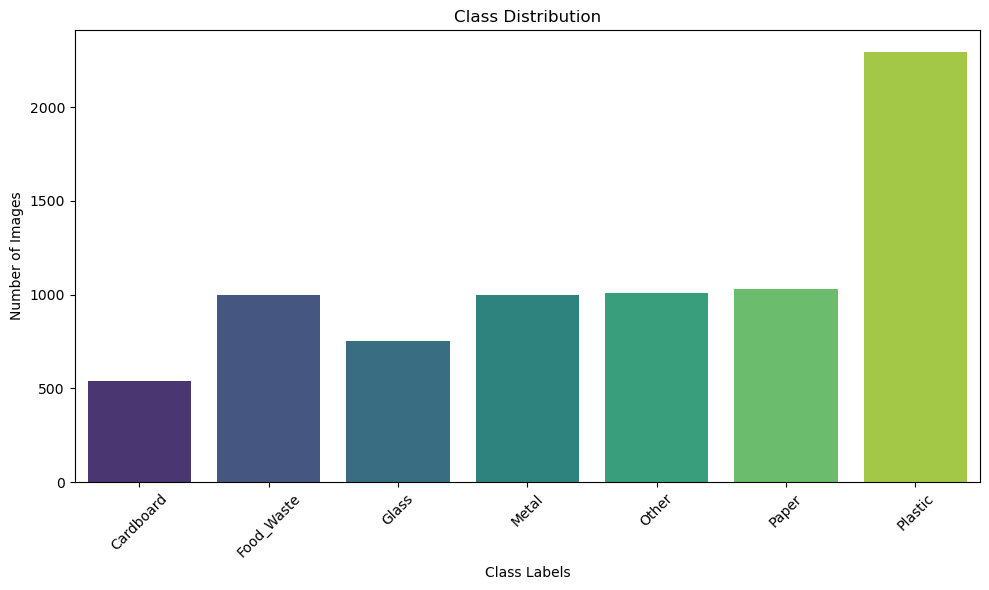

In [6]:
# Visualise Data Distribution
from collections import Counter

def plot_class_distribution(labels, title="Class Distribution"):
    label_counts = Counter(labels)
    classes = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=classes, y=counts, palette="viridis", hue=classes)
    plt.title(title)
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(y)


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

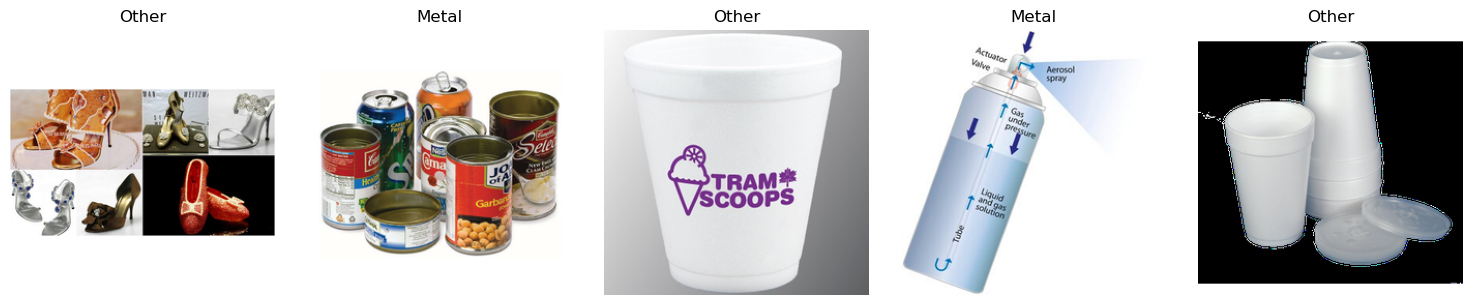

In [7]:
# Visualise Sample Images (across different labels)
def show_images_from_array(images, labels=None, class_names=None, num_samples=5):
    plt.figure(figsize=(15, 3))
    #show different images everytime!
    random_indices = np.random.choice(len(X), size=num_samples, replace=False)
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        ax.imshow(images[random_indices[i]])
        if labels is not None:
            label = labels[random_indices[i]]
            if class_names is not None:
                label = class_names[label] if isinstance(label, int) else label
            ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
show_images_from_array(X, y, class_names)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [8]:
# Find the smallest and largest image dimensions from the data set
def find_smallest_largest_image_sizes(images):
    min_size = None
    max_size = None
    min_index = -1
    max_index = -1

    for i, img in enumerate(images):
        h, w = img.shape[:2]
        area = h * w

        if min_size is None or area < min_size[0] * min_size[1]:
            min_size = (h, w)
            min_index = i

        if max_size is None or area > max_size[0] * max_size[1]:
            max_size = (h, w)
            max_index = i

    print(f"Smallest image: index {min_index}, size {min_size}")
    print(f"Largest image: index {max_index}, size {max_size}")
    return min_index, max_index, min_size, max_size

min_idx, max_idx, min_sz, max_sz = find_smallest_largest_image_sizes(X)

# the smallest and the largest image size are both at index 0
# that implied all spplied images are of same size

Smallest image: index 0, size (256, 256)
Largest image: index 0, size (256, 256)


In [9]:
# Resize the image dimensions

# if I add images, then I will need to resize, hence writing the user defined function
target_x, target_y = 256, 256
def resize_images(images, target_size=(target_x, target_y)):
    resized = []
    for img in images:
        pil_img = Image.fromarray(img)
        pil_img = pil_img.resize(target_size)
        resized.append(np.array(pil_img))
    return np.array(resized)

X_resized = resize_images(X)
print("New shape:", X_resized.shape)

New shape: (7625, 256, 256, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [10]:
# Encode the labels suitably
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("Class mapping:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

y_onehot = to_categorical(y_encoded)

num_samples = 5
random_indices = np.random.choice(len(X), size=num_samples, replace=False)
for i in range(num_samples):
    print("Original labels:", y[random_indices[i]])
    print("Encoded labels:", y_encoded[random_indices[i]])
    print("One-hot labels:", y_onehot[random_indices[i]])


Class mapping: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}
Original labels: Cardboard
Encoded labels: 0
One-hot labels: [1. 0. 0. 0. 0. 0. 0.]
Original labels: Plastic
Encoded labels: 6
One-hot labels: [0. 0. 0. 0. 0. 0. 1.]
Original labels: Paper
Encoded labels: 5
One-hot labels: [0. 0. 0. 0. 0. 1. 0.]
Original labels: Paper
Encoded labels: 5
One-hot labels: [0. 0. 0. 0. 0. 1. 0.]
Original labels: Plastic
Encoded labels: 6
One-hot labels: [0. 0. 0. 0. 0. 0. 1.]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [11]:
# Assign specified parts of the dataset to train and validation sets
from sklearn.model_selection import train_test_split

# Split into 80% training and 20% testing
X_train, X_test, X_resized_train, X_resized_test, y_train, y_test, y_encoded_train, y_encoded_test, y_onehot_train, y_onehot_test = train_test_split(
    X, X_resized, y, y_encoded, y_onehot, test_size=0.3, random_state=42, stratify=y
)

print("X_train size:", len(X_train))
print("X_test  size:", len(X_test))
print("X_resized_train size:", len(X_train))
print("X_resized_test  size:", len(X_test))
print("y_train size:", len(X_train))
print("y_test  size:", len(X_test))
print("y_encoded_train size:", len(X_train))
print("y_encoded_test  size:", len(X_test))
print("y_onehot_train size:", len(X_train))
print("y_onehot_test  size:", len(X_test))

X_train size: 5337
X_test  size: 2288
X_resized_train size: 5337
X_resized_test  size: 2288
y_train size: 5337
y_test  size: 2288
y_encoded_train size: 5337
y_encoded_test  size: 2288
y_onehot_train size: 5337
y_onehot_test  size: 2288


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [12]:
# Build and compile the model
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

def build_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    #input shape
    model.add(tf.keras.Input(shape=input_shape))

    # Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Conv Block 3
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Fully Connected Layers
    #model.add(layers.Flatten())
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  # use categorical_crossentropy if labels are one-hot
        metrics=['accuracy']
    )

    return model

input_shape = X_resized_train.shape[1:]  # e.g., (256, 256, 3)
print(input_shape)

num_classes = len(set(y_train))  # or use len(np.unique(y_train))

model = build_cnn_model(input_shape, num_classes)
model.summary()

(256, 256, 3)


2025-09-10 23:37:02.913771: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-09-10 23:37:02.913802: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-09-10 23:37:02.913807: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-09-10 23:37:02.913822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-10 23:37:02.913831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,831 (241.53 KB)

 Trainable params: 61,383 (239.78 KB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

Num GPUs Available:  1
Epoch 1/30


2025-09-10 23:37:12.680459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.2576 - loss: 2.8781 - val_accuracy: 0.1324 - val_loss: 2.5327
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.3161 - loss: 2.4484 - val_accuracy: 0.1241 - val_loss: 2.4765
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.3508 - loss: 2.2338 - val_accuracy: 0.1691 - val_loss: 2.4781
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.3738 - loss: 2.0657 - val_accuracy: 0.2330 - val_loss: 2.3634
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.3901 - loss: 1.9410 - val_accuracy: 0.3418 - val_loss: 2.3038
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.4085 - loss: 1.8185 - val_accuracy: 0.3523 - val_loss: 1.9708
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.4081 - loss: 1.7727 - val_accuracy: 0.1962 - val_loss: 2.6891
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.4276 - loss: 1.6866 - val_accuracy: 0.349

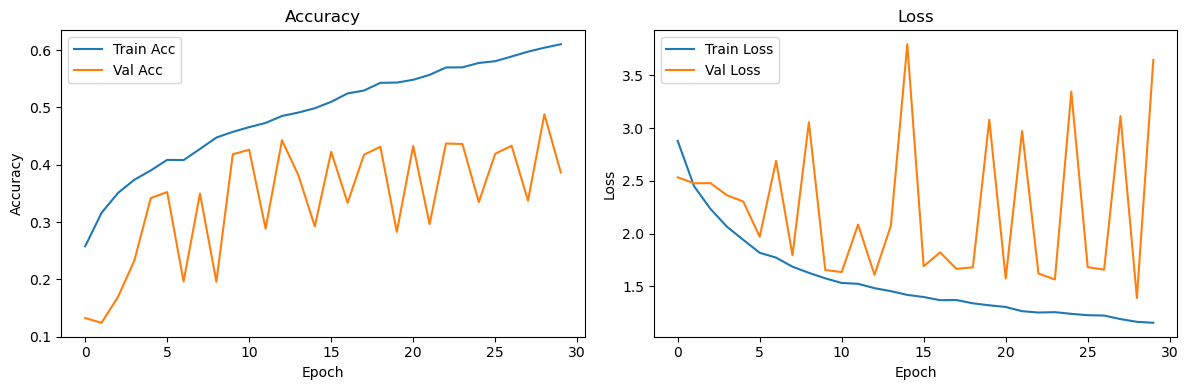

In [13]:
# Training
X_resized_train = X_resized_train / (target_x - 1)
X_resized_test = X_resized_test / (target_x - 1)

# had to switch to tf.data.Dataset because the kernel crashed
train_ds = tf.data.Dataset.from_tensor_slices((X_resized_train, y_encoded_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_resized_test, y_encoded_test))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


BATCH_SIZE =64

train_ds = (
    train_ds
    .shuffle(buffer_size=len(X_resized_train))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    verbose=1
)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [14]:
# Evaluate on the test set; display suitable metrics
#This is combined with model fit, see above.

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [15]:
# Define augmentation steps to augment images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [16]:
# Create a function to augment the images
datagen.fit(X_resized_train)

train_generator = datagen.flow(
    X_resized_train, y_encoded_train,
    batch_size=32,
    shuffle=True
)

In [17]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

/opt/anaconda3/envs/cnn_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.5428 - loss: 1.3245 - val_accuracy: 0.4414 - val_loss: 1.5979
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.5482 - loss: 1.3108 - val_accuracy: 0.5101 - val_loss: 1.4620
Epoch 3/30
 1/83 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.5312 - loss: 1.2159

/opt/anaconda3/envs/cnn_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5312 - loss: 1.2159 - val_accuracy: 0.5061 - val_loss: 1.4616
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.5591 - loss: 1.2882 - val_accuracy: 0.2032 - val_loss: 5.4314
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.5613 - loss: 1.2930 - val_accuracy: 0.4725 - val_loss: 1.4752
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6875 - loss: 1.0572 - val_accuracy: 0.4760 - val_loss: 1.4656
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.5674 - loss: 1.2735 - val_accuracy: 0.3934 - val_loss: 2.3188
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.5633 - loss: 1.2916 - val_accuracy: 0.4908 - val_loss: 1.4589
Epoch 9/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4375 - loss: 1.4528 - val_accuracy: 0.4956 - val_loss: 1.4395
Epoch 10/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.5670 - loss: 1.2743 - val_accuracy: 0.3658 - v

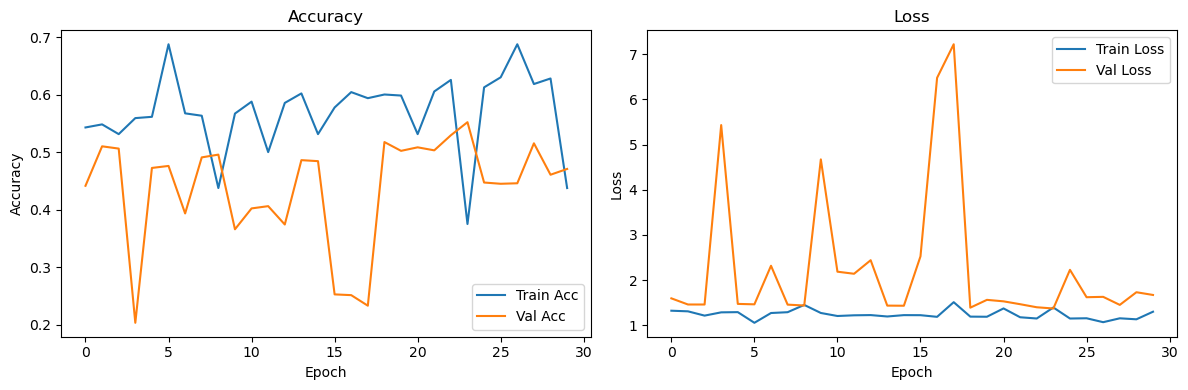

In [18]:
# Train the model using augmented images

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_resized_train) // BATCH_SIZE,
    validation_data=test_ds,
    epochs=30,
    verbose=1,
)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
The data had consistent size. It is a little high on plastic, perhaps in line with reality.
* Report model training results
The model was affected by data size 32x32, 64x64, 128x128, 256x256. 128x128 was optimal.
I learnt how to leverage the GPU of my machine, after exhausted the resources at Google colab.

Things I would like to try:
- use of hyperparameter tuning
- configure more layers and normalisation
- use one hot encoding and do multi-classification.
- more/better data augmentation.
